# **Task 3 : Twitter Sentiment Analysis**

**PROJECT AIM**: The primary aim of conducting Twitter sentiment analysis is to automatically assess the emotions and opinions expressed in tweets, providing valuable insights into public sentiment on various topics, brands, events, or products. This can help organizations, researchers, and policymakers understand how people feel, detect trends, and make informed decisions by analyzing large-scale user-generated content in real time.

# **IMPORTING LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import matplotlib.patches as mpatches
import seaborn as sns

import re 

#Word2Vec
import gensim  # Imports the Gensim library, used for topic modeling and word embeddings like Word2Vec.
from gensim.test.utils import common_texts  # Imports a sample dataset (`common_texts`) provided by Gensim for testing purposes.
from gensim.models import Word2Vec  # Imports the Word2Vec model for training word embeddings based on text data.

#NTLK
from nltk.corpus import stopwords  # Imports a list of common stopwords from the NLTK library to filter out non-informative words during text processing.
from nltk.stem.snowball import SnowballStemmer   # Imports the Snowball Stemmer for reducing words to their root form.


# WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict

import warnings
warnings.filterwarnings("ignore")

# **LOADING DATA**

In [2]:
data=pd.read_csv('/kaggle/input/twitter-data/Twitter_Data.csv')
data.head(20)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
5,kiya tho refresh maarkefir comment karo,0.0
6,surat women perform yagna seeks divine grace f...,0.0
7,this comes from cabinet which has scholars lik...,0.0
8,with upcoming election india saga going import...,1.0
9,gandhi was gay does modi,1.0


# **DATA EXPLORATION**

In [3]:
data.shape

(162980, 2)

In [4]:
data.sample(5)

,clean_text,category
155836,strange comparison modi was from gujarat but h...,1.0
48892,narendra modi reveals india turns ‘maha shakti...,1.0
141238,seems more poisonous than modi advani shefali ...,1.0
15312,this for the people out there who are fed this...,1.0
40660,chidambram says that minimum income program co...,-1.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [6]:
data['category'].value_counts()

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64

In [7]:
print(data['clean_text'][38])

print(data['clean_text'][89])

people wish your vision india and least interested about your personal enmity with modi others its your personal problem handle this personally and dont expect nation will join your dirty fight with others tell why vote 
this face doesn’ haunt you condemn the abduction girls but they’ alive and wel also recorded message still our personally ordered action unlike modi who treats muslims just vote bank


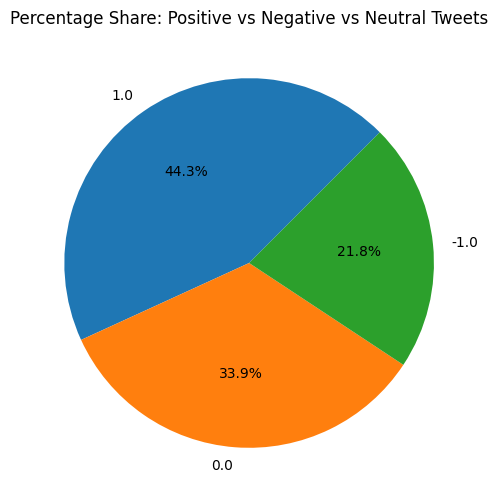

In [8]:
# Checking the categories distribution in percentage
category_counts = data['category'].value_counts()  # Get counts of each category
plt.figure(figsize=[6, 6])  # Increase the size for better readability
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%',startangle=45)  # Adds a starting angle for better orientation
plt.title('Percentage Share: Positive vs Negative vs Neutral Tweets')  # Slightly refined title
plt.show()  # Display the pie chart


# **DATA CLEANING**

In [9]:
data.duplicated().sum()
data.drop_duplicates()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [10]:
data.isnull().sum()

clean_text    4
category      7
dtype: int64

In [11]:
data.dropna(subset=['clean_text','category'])

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [12]:
# Replace NaN values with an empty string and convert all entries to strings
data['clean_text'] = data['clean_text'].fillna('').astype(str)

In [13]:
# Compile a regular expression pattern to match any non-alphabetic characters
pattern = re.compile('[^a-zA-Z]')

# Retrieve the list of English stopwords
english_stopwords = stopwords.words('english')

# Initialize the Snowball Stemmer for English
snow_stemmer = SnowballStemmer(language='english')


In [14]:
def preprocessed_text(text):
    if not isinstance(text, str):
        return ''  # Handle non-string input
    
    # Remove non-alphabetic characters
    cleaned_text = re.sub(pattern, ' ', text)
    
    # Convert to lowercase and process further
    cleaned_text = cleaned_text.lower()
    words = cleaned_text.split()
    stemmed_words = [snow_stemmer.stem(word) for word in words if word not in english_stopwords]
    stemmed_content = ' '.join(stemmed_words)
    
    return stemmed_content

In [15]:
# Apply the preprocessing function
data['stemmed_content'] = data['clean_text'].apply(preprocessed_text)

In [16]:
data.head(10)

,clean_text,category,stemmed_content
0,when modi promised “minimum government maximum...,-1.0,modi promis minimum govern maximum govern expe...
1,talk all the nonsense and continue all the dra...,0.0,talk nonsens continu drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcom bjp told rahul main campa...
3,asking his supporters prefix chowkidar their n...,1.0,ask support prefix chowkidar name modi great s...
4,answer who among these the most powerful world...,1.0,answer among power world leader today trump pu...
5,kiya tho refresh maarkefir comment karo,0.0,kiya tho refresh maarkefir comment karo
6,surat women perform yagna seeks divine grace f...,0.0,surat women perform yagna seek divin grace nar...
7,this comes from cabinet which has scholars lik...,0.0,come cabinet scholar like modi smriti hema tim...
8,with upcoming election india saga going import...,1.0,upcom elect india saga go import pair look cur...
9,gandhi was gay does modi,1.0,gandhi gay modi


 # **DATA VISUALIZATION**

In [17]:
# Segrating based on different sentiments
data_negative = data[data["category"]==-1]
data_positive = data[data["category"]==1]
data_neutral = data[data["category"]==0]

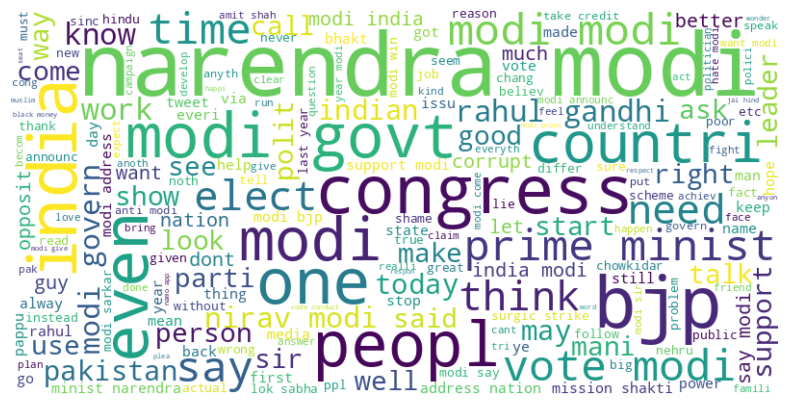

In [18]:
# Combine all text into a single string
text_combined = ' '.join(data['stemmed_content'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.show()

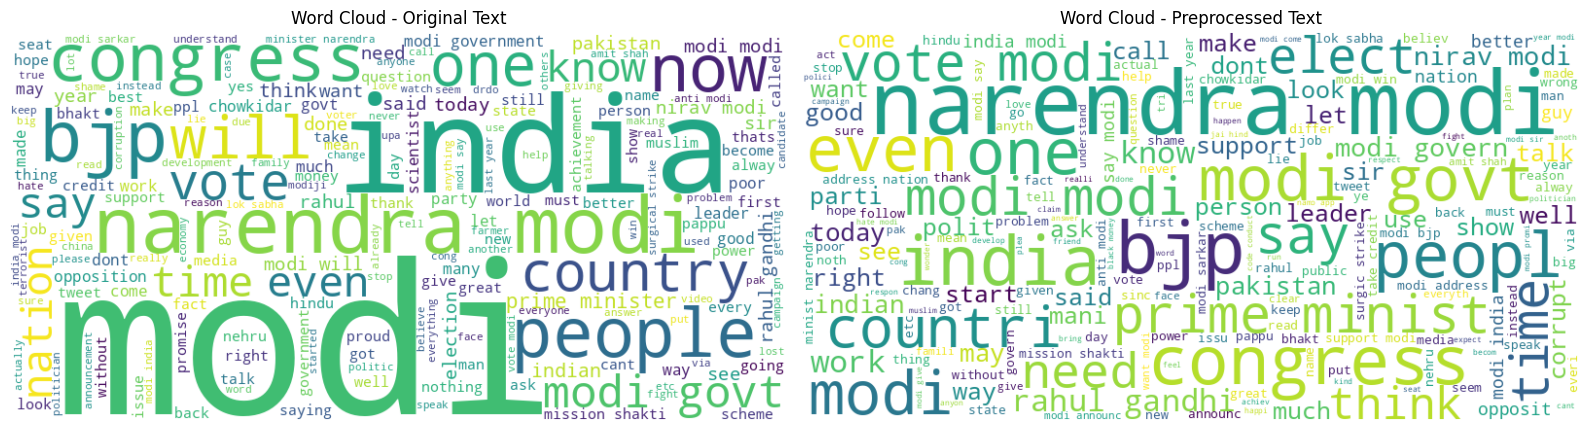

In [19]:
# Concatenate all the original and preprocessed texts into a single string for word cloud generation
original_text = ' '.join(data['clean_text'].tolist())
preprocessed_texts = ' '.join(data['clean_text'].apply(preprocessed_text).tolist())

# Generate the word cloud for original text
wordcloud_original = WordCloud(width=800, height=400, background_color='white').generate(original_text)

# Generate the word cloud for preprocessed text
wordcloud_preprocessed = WordCloud(width=800, height=400, background_color='white').generate(preprocessed_texts)

# Plotting the word clouds side by side
plt.figure(figsize=(16, 8))

# Plot original word cloud
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.title('Word Cloud - Original Text')
plt.axis('off')

# Plot preprocessed word cloud
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.imshow(wordcloud_preprocessed, interpolation='bilinear')
plt.title('Word Cloud - Preprocessed Text')
plt.axis('off')

plt.tight_layout()  # Adjust layout so plots don't overlap
plt.show()

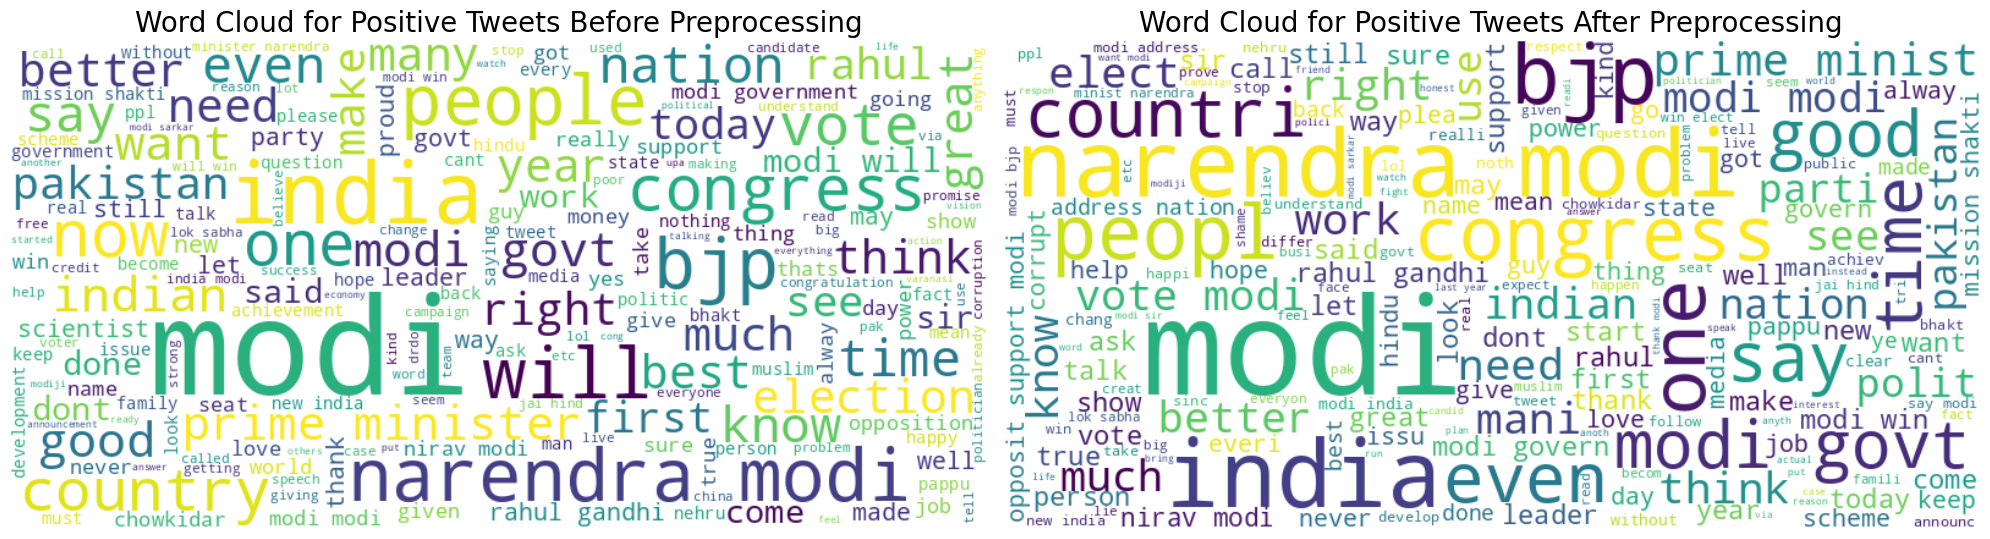

In [20]:
# Assuming your dataset 'data' has a 'category' column, filter for positive tweets
data_positive = data[data['category'] == +1]

# Concatenate all the positive tweets before and after preprocessing
all_words_raw_positive = " ".join(data_positive['clean_text'])  # Before preprocessing
all_words_processed_positive = " ".join(data_positive['stemmed_content'])  # After preprocessing

# Create word clouds for raw and processed text
wordcloud_raw_positive = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_words_raw_positive)
wordcloud_processed_positive = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_words_processed_positive)

# Create subplots to display both word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(20,10))

# Plot the raw text word cloud
axes[0].imshow(wordcloud_raw_positive, interpolation='bilinear')
axes[0].set_title('Word Cloud for Positive Tweets Before Preprocessing', fontsize=20)
axes[0].axis('off')

# Plot the processed text word cloud
axes[1].imshow(wordcloud_processed_positive, interpolation='bilinear')
axes[1].set_title('Word Cloud for Positive Tweets After Preprocessing', fontsize=20)
axes[1].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

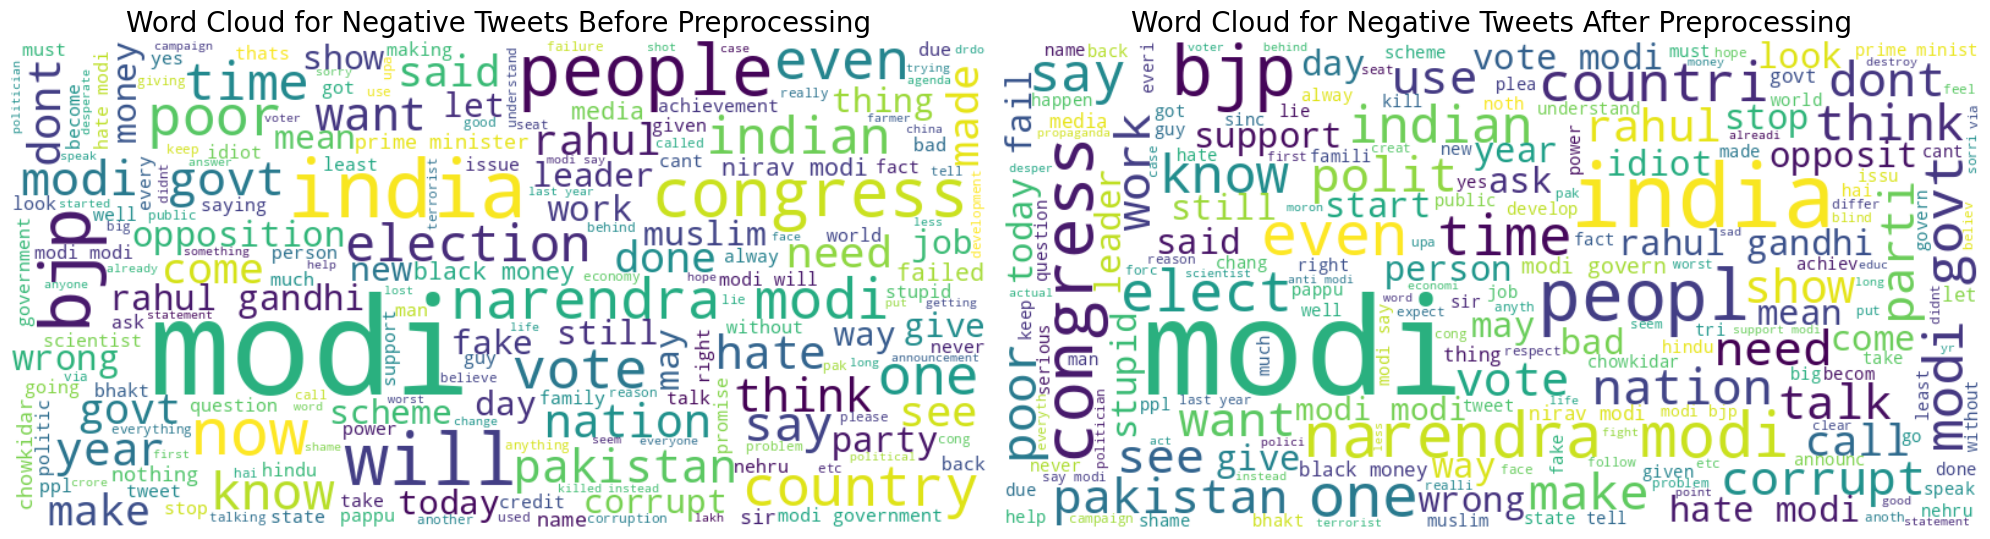

In [21]:
# Assuming your dataset 'data' has a 'category' column, filter for negative tweets
data_negative = data[data['category'] == -1]

# Concatenate all the negative tweets before and after preprocessing
all_words_raw_negative = " ".join(data_negative['clean_text'])  # Before preprocessing
all_words_processed_negative = " ".join(data_negative['stemmed_content'])  # After preprocessing

# Create word clouds for raw and processed text
wordcloud_raw_negative = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_words_raw_negative)
wordcloud_processed_negative = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_words_processed_negative)

# Create subplots to display both word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(20,10))

# Plot the raw text word cloud for negative tweets
axes[0].imshow(wordcloud_raw_negative, interpolation='bilinear')
axes[0].set_title('Word Cloud for Negative Tweets Before Preprocessing', fontsize=20)
axes[0].axis('off')

# Plot the processed text word cloud for negative tweets
axes[1].imshow(wordcloud_processed_negative, interpolation='bilinear')
axes[1].set_title('Word Cloud for Negative Tweets After Preprocessing', fontsize=20)
axes[1].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

# Splitting Input Matrix Feature and Target Feature

In [22]:
# Separating the data and label
X = data['stemmed_content']
y = data['category']

In [23]:
# Remove rows with missing labels
data = data.dropna(subset=['category'])

# Re-run your train-test split
X = data['stemmed_content']
y = data['category']

# Splitting data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

# FEATURE EXTRACTION

In [24]:
# Converting textual data into numerical
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# **NAIVE BAYES MODEL**

In [25]:
#Initialize the Multinomial Naive Bayes classifier
best_accuracy = 0
a = 0.1
while a <= 1:
  nb = MultinomialNB(alpha=a)

  #Fitting the model
  nb.fit(X_train_tfidf, y_train)
  curr_accuracy = nb.score(X_test_tfidf, y_test)
  print(f"Accuracy with alpha {a}: {curr_accuracy*100}")
  # Predict the labels
  if curr_accuracy > best_accuracy:
    best_accuracy = curr_accuracy
    y_pred = nb.predict(X_test_tfidf)
  a = a + 0.05

Accuracy with alpha 0.1: 65.47630004601933
Accuracy with alpha 0.15000000000000002: 65.12348519711612
Accuracy with alpha 0.2: 64.684767602393
Accuracy with alpha 0.25: 64.19389476913638
Accuracy with alpha 0.3: 63.7919926369075
Accuracy with alpha 0.35: 63.21214910262311
Accuracy with alpha 0.39999999999999997: 62.724344224574324
Accuracy with alpha 0.44999999999999996: 62.08314158613284
Accuracy with alpha 0.49999999999999994: 61.524773738303416
Accuracy with alpha 0.5499999999999999: 60.96640589047399
Accuracy with alpha 0.6: 60.44792146034668
Accuracy with alpha 0.65: 59.932504985427215
Accuracy with alpha 0.7000000000000001: 59.475379659456976
Accuracy with alpha 0.7500000000000001: 58.9998466022396
Accuracy with alpha 0.8000000000000002: 58.594876514802884
Accuracy with alpha 0.8500000000000002: 58.24206166589968
Accuracy with alpha 0.9000000000000002: 57.806412026384415
Accuracy with alpha 0.9500000000000003: 57.435189446234084


In [26]:
# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 2529   761  3812]
 [  394  6006  4643]
 [  600  1043 12807]]


## EVALUATE PERFORMANCE

In [27]:
# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.72      0.36      0.48      7102
         0.0       0.77      0.54      0.64     11043
         1.0       0.60      0.89      0.72     14450

    accuracy                           0.65     32595
   macro avg       0.70      0.60      0.61     32595
weighted avg       0.68      0.65      0.64     32595



## PREDICTION USING NAIVE BAYES MODEL

In [28]:
import re
from bs4 import BeautifulSoup
import string
# Function definitions for cleaning
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF""]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    return BeautifulSoup(text, "lxml").text

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)

def clean_tweet_text(text):
    return text.strip()

# Prediction function
def predict_tweet(tweet, model, vectorizer):
    # Preprocess the input tweet
    tweet = remove_URL(tweet)
    tweet = remove_emoji(tweet)
    tweet = remove_html(tweet)
    tweet = remove_punct(tweet)
    tweet = remove_quotes(tweet)
    tweet = tweet.lower()
    tweet = clean_tweet_text(tweet)
    
    # Transform the tweet using the TF-IDF vectorizer
    tweet_tfidf = vectorizer.transform([tweet])
    
    # Predict the label
    prediction = model.predict(tweet_tfidf)
    # Convert 0 to -1 for negative sentiment
    if prediction[0] == 0:
        return -1
    return prediction[0]

# Example usage
new_text =  "The service was terrible, and I had to wait for an hour. Definitely not coming back! #disappointed #badservice"
predicted_sentiment= predict_tweet(new_text, nb, vectorizer)

# Print the result with the sentiment label
sentiment_label = "Positive" if predicted_sentiment == 1 else "Negative"
score_label = predicted_sentiment  # Will now output either 1 or -1
print(f"Predicted Sentiment: {sentiment_label}, Score: {score_label}")

Predicted Sentiment: Negative, Score: -1


# **LOGISTIC REGRESSION MODEL**

In [29]:
# Logistic Regression model
lr = LogisticRegression(max_iter=1000)

# Fit
lr.fit(X_train_tfidf, y_train)

# Predictions
y_pred = lr.predict(X_test_tfidf)

In [30]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}')

Accuracy: 84.48


## EVALUATE PERFORMANCE

In [31]:
# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.83      0.71      0.76      7102
         0.0       0.82      0.91      0.86     11043
         1.0       0.87      0.86      0.87     14450

    accuracy                           0.84     32595
   macro avg       0.84      0.83      0.83     32595
weighted avg       0.85      0.84      0.84     32595



In [32]:
# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 5032   938  1132]
 [  321 10051   671]
 [  744  1253 12453]]


## PREDICTION USING LOGISTIC REGRESSION MODEL

In [33]:
new_text = "Great match tonight! Our team played exceptionally well and secured a decisive victory. #football #winning"
predicted_sentiment= predict_tweet(new_text, lr, vectorizer)

# Print the result with the sentiment label
sentiment_label = "Positive" if predicted_sentiment == 1 else "Negative"
print(f"Predicted Sentiment: {sentiment_label}, Score: {predicted_sentiment}")

Predicted Sentiment: Positive, Score: 1.0


# **Word2Vec Analysis**

In [34]:
TRAIN_SIZE = 0.8

# Parameters for WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Parameters related to KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024
data_train, data_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)

documents = [text.split() for text in data_train.clean_text]

## Word2Vec Model Creation

In [35]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

## VOCABULARY CREATION

In [36]:
w2v_model.build_vocab(documents)
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 12334


## MODEL TRAINING

In [37]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(65235440, 83675968)

## MODEL TESTING

In [38]:
w2v_model.wv.most_similar("india")

[('country', 0.6052238345146179),
 ('nation', 0.5057605504989624),
 ('our', 0.40164077281951904),
 ('indias', 0.3733326196670532),
 ('indian', 0.3670963644981384),
 ('indians', 0.36131927371025085),
 ('nations', 0.35713785886764526),
 ('world', 0.331903874874115),
 ('countries', 0.3199021518230438),
 ('diversity', 0.3191428482532501)]

In [39]:
w2v_model.wv.most_similar("narendra")

[('narendrabhai', 0.4579496383666992),
 ('narender', 0.44399625062942505),
 ('priminister', 0.4203226566314697),
 ('honourable', 0.3649479150772095),
 ('mrnarendra', 0.3209691047668457),
 ('nrendra', 0.29359138011932373),
 ('narendar', 0.29198476672172546),
 ('narenda', 0.28639400005340576),
 ('naredra', 0.270721971988678),
 ('groundbreaking', 0.27046632766723633)]